# Fine-tuning Trained CNN classifier on noisy data

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models.utils import test_classifier, identify_device
from torch.utils.data import DataLoader, TensorDataset

from models.Classifier_models import CNN1D_Large, train_model

Using device: mps

 Unseen dataset Accuracy: 0.9591

------------- F1 metrics -------------
Macro F1: 0.959
Weighted F1: 0.959
Layer 1: F1 Score = 0.994
Layer 2: F1 Score = 0.941
Layer 3: F1 Score = 0.942


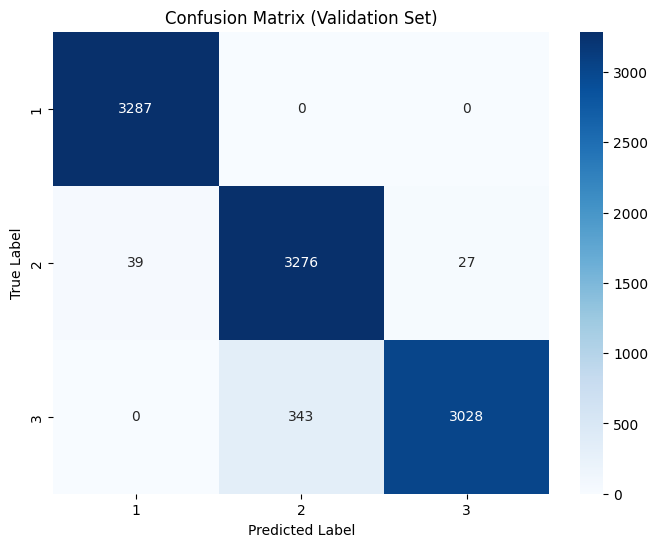

In [4]:
device = identify_device()
model = CNN1D_Large()
model.load_state_dict(torch.load('trained_models/large_CNN.pth', map_location=torch.device('cpu')))
model.to(device)

_ = test_classifier(model, 'data/Validation.pt', device=device)

In [5]:
noisy_data = torch.load("data/finetune_noise_1eneg3.pt", weights_only=False)

noisy_pulses = noisy_data['synthetic_data']
num_layers = noisy_data["num_layers"]

num_layers_adjusted = num_layers - 1  # Convert labels from 1–3 → 0–2

print("Dataset loaded successfully!")
print(f"Number of samples: {len(noisy_pulses)}")
print(f"Shape of synthetic_data: {noisy_pulses.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", noisy_pulses.unsqueeze(1).shape)
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])

num_classes = int(num_layers_adjusted.max().item()) + 1  
batch_size = 64

noisy_pulses = noisy_pulses.unsqueeze(1)

noisy_dataset = TensorDataset(noisy_pulses, num_layers_adjusted)
train_loader = DataLoader(noisy_dataset, batch_size=batch_size, shuffle=True)

Dataset loaded successfully!
Number of samples: 15000
Shape of synthetic_data: torch.Size([15000, 1024])
Shape of num_layers: torch.Size([15000])
Example number of layers: tensor([2, 1, 1, 3, 2, 2, 1, 1, 1, 3])
synthetic_data shape (after unsqueeze): torch.Size([15000, 1, 1024])
num_layers_adjusted (for training): tensor([1, 0, 0, 2, 1, 1, 0, 0, 0, 2])


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

train_loss, train_acc, val_loss, val_acc, lr_vals = train_model(
    model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=15,
    verbose='batch'
)

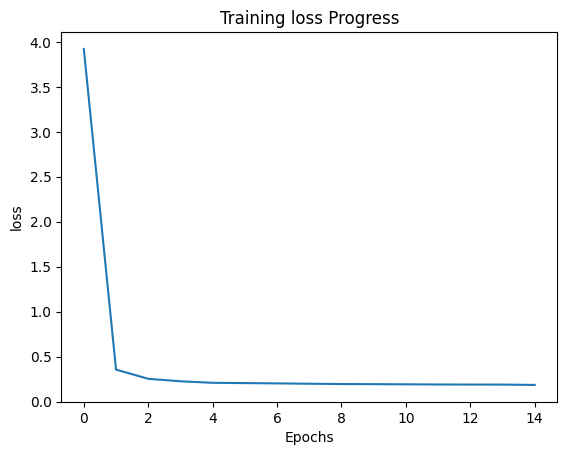

In [7]:
# Plot the acuracy values
plt.plot(train_loss, label='training')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

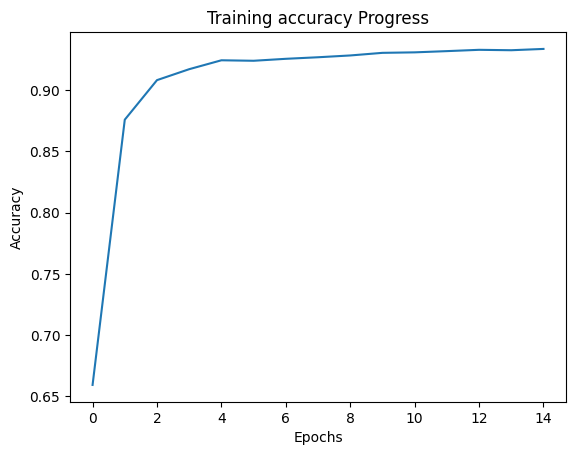

In [8]:
# Plot the accuracy values
plt.plot(train_acc, label='training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy Progress')
plt.show()

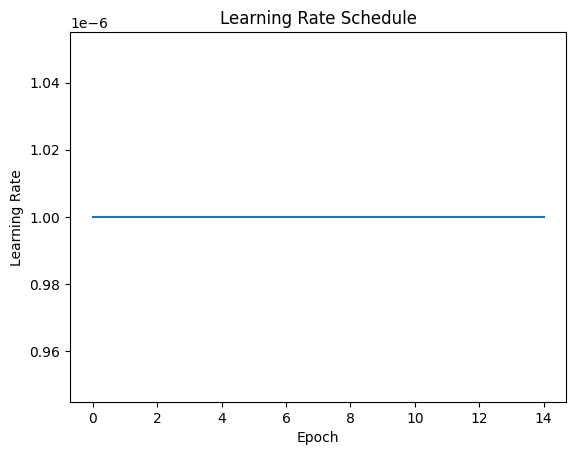

In [9]:
plt.plot(lr_vals)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

Noisy Unseen set

 Unseen dataset Accuracy: 0.9454

------------- F1 metrics -------------
Macro F1: 0.945
Weighted F1: 0.945
Layer 1: F1 Score = 0.987
Layer 2: F1 Score = 0.921
Layer 3: F1 Score = 0.928


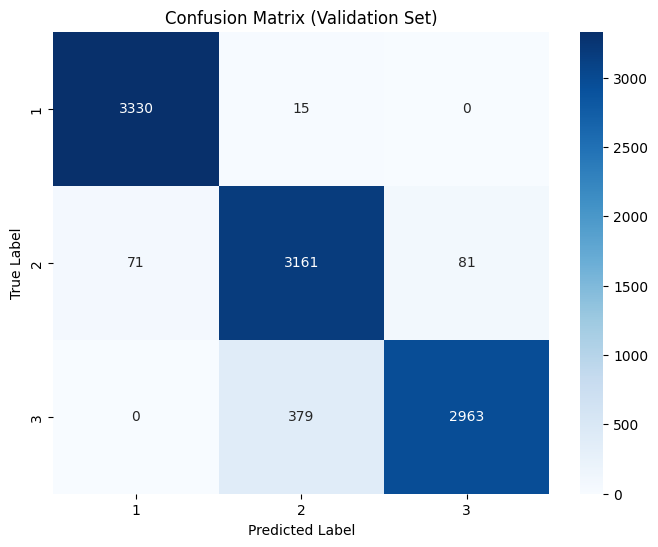

In [12]:
print('Noisy Unseen set')
test_classifier(model, 'data/Validation_noise_1eneg3.pt', device=device)

Clean Dataset

 Unseen dataset Accuracy: 0.9101

------------- F1 metrics -------------
Macro F1: 0.910
Weighted F1: 0.909
Layer 1: F1 Score = 0.972
Layer 2: F1 Score = 0.876
Layer 3: F1 Score = 0.882


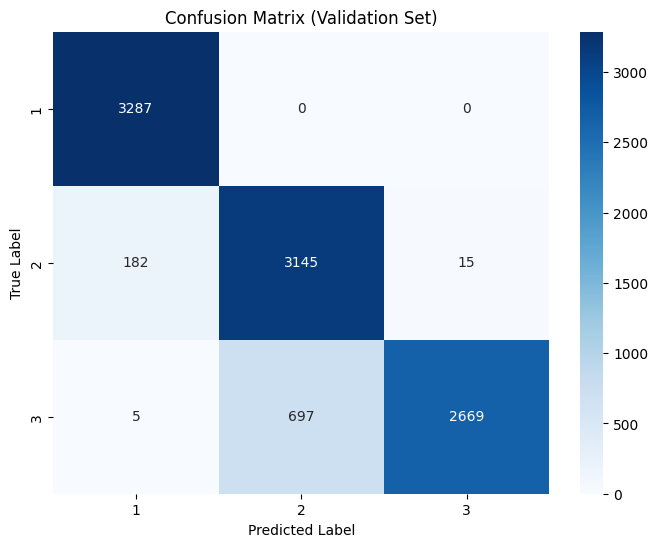

In [13]:
print('Clean Dataset')
test_classifier(model, 'data/Validation.pt', device=device)